[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


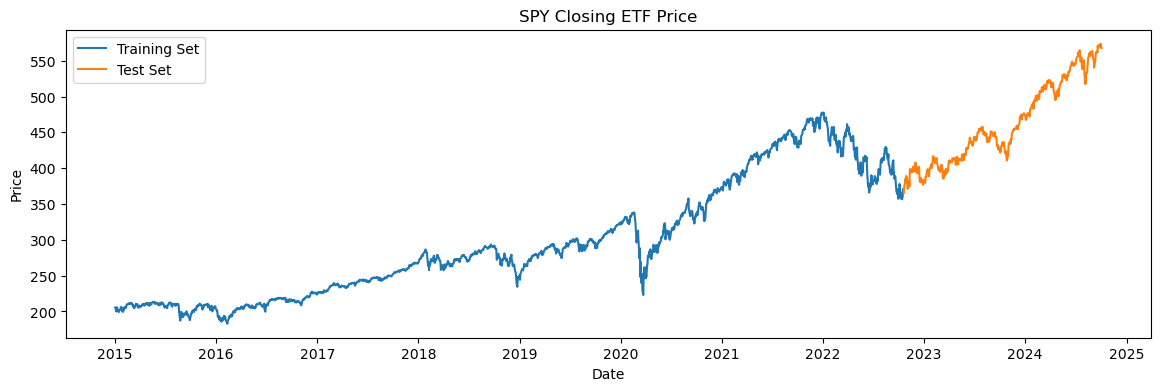

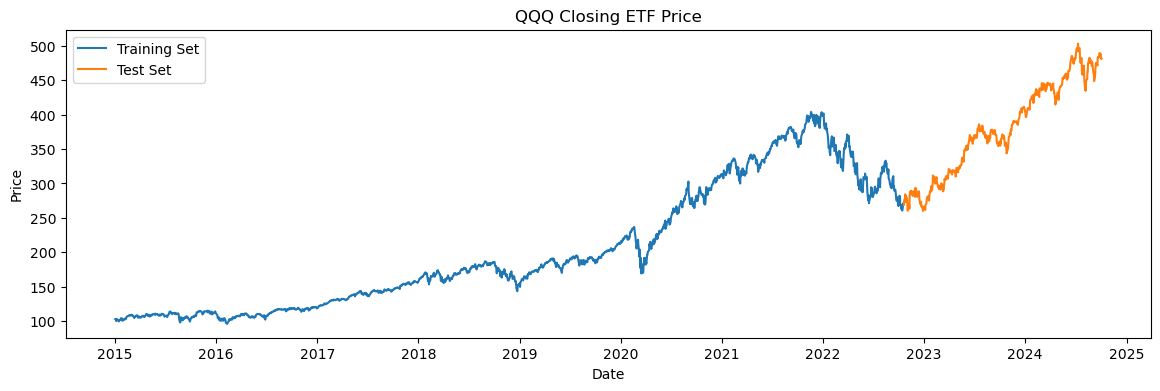

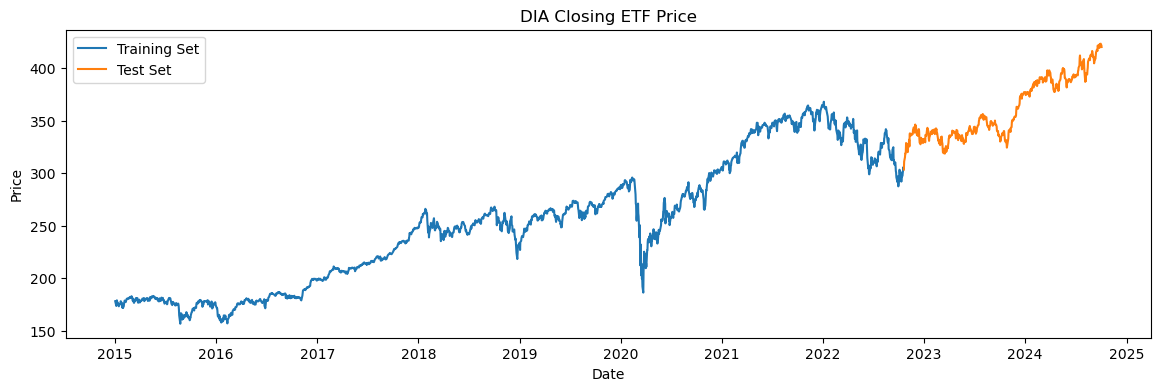

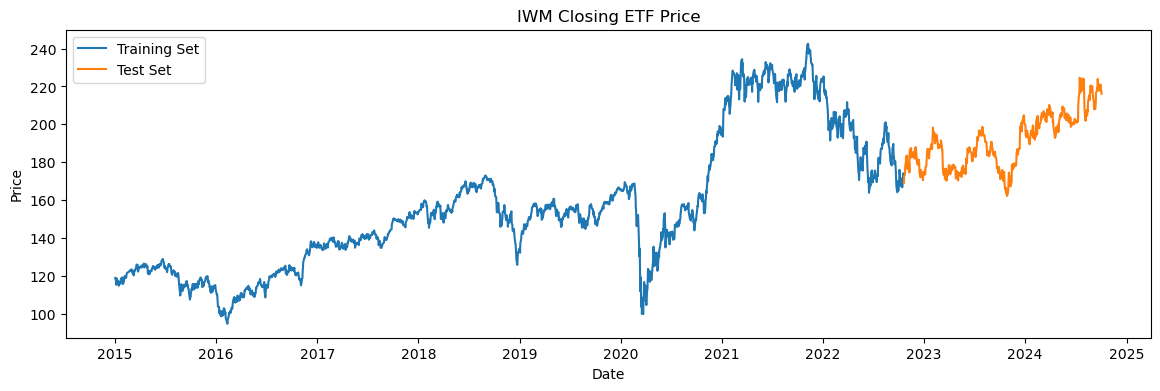

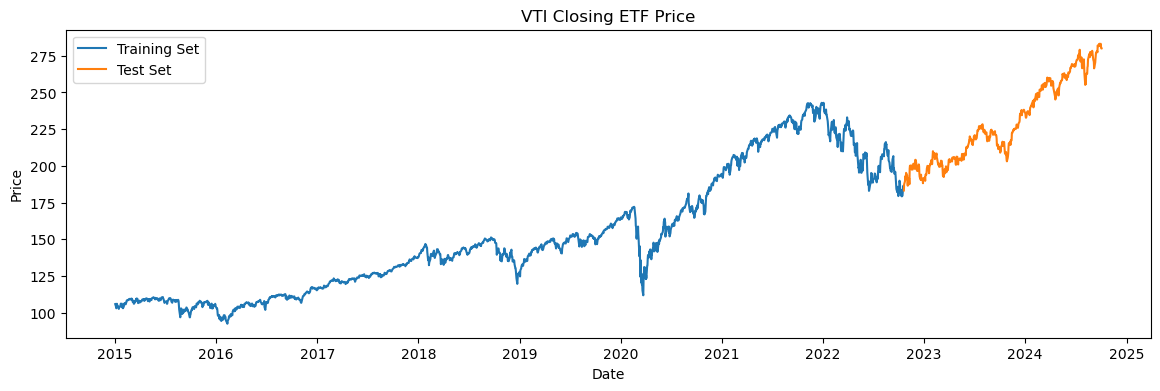

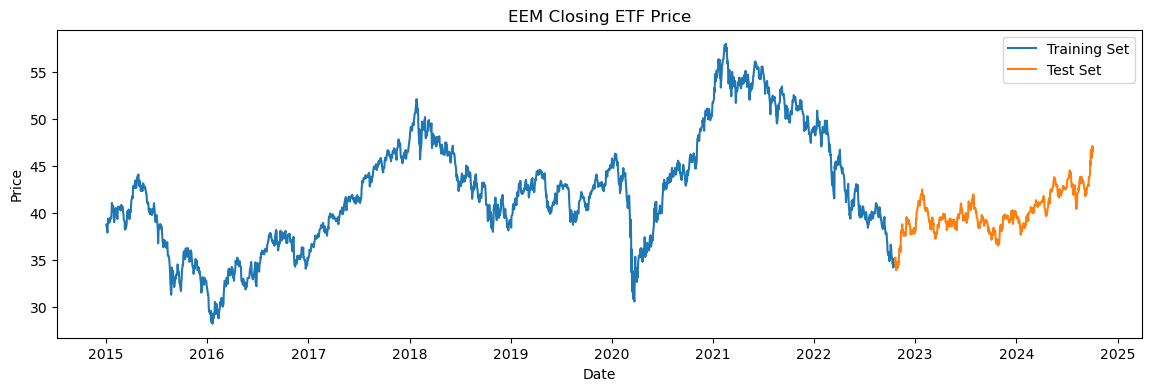

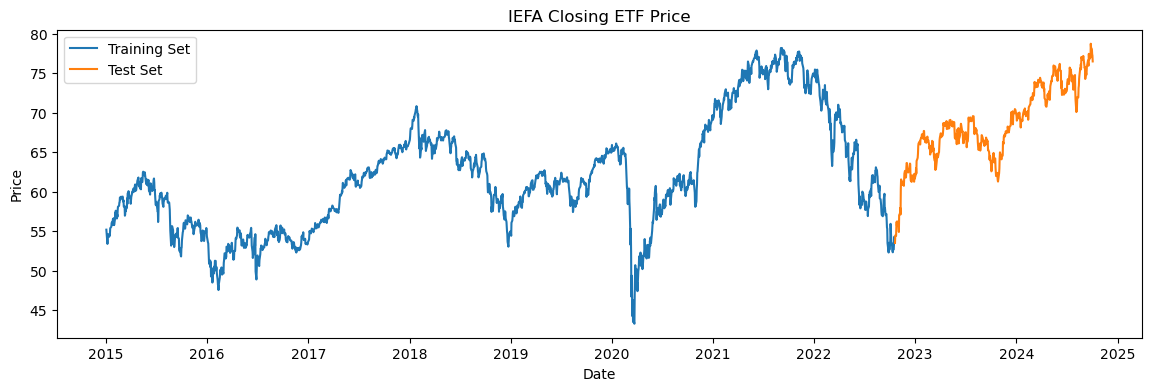

In [8]:
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# Define ETF list
etfList = ["SPY", "QQQ", "DIA", "IWM", "VTI", "EEM", "IEFA"]

# Set date range (start from 2015)
START = "2015-01-01"
TODAY = datetime.today().strftime("%Y-%m-%d")

# Define a function to load the dataset
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    #data.reset_index(inplace=True)  # Reset index to make Date a column
    return data

def train_test_split(dataframe, col):
    split_index = int(len(dataframe) * 0.8)  # 80% for training
    train = dataframe.iloc[:split_index][col]  # Training set (first 80%)
    test = dataframe.iloc[split_index:][col]   # Test set (remaining 20%)
    return train, test


# Fetch and split data into train/test sets for each ETF
df_new = {}
for i in etfList:
    df_ = load_data(i)  # Load the dataset for the ETF
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = train_test_split(df_, "Close")  # Split into 80% train, 20% test

# Plot all ETFs, showing training and test sets
for i in etfList:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"], label='Training Set')
    plt.plot(df_new[i]["Test"], label='Test Set')
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend()
    plt.title(i + " Closing ETF Price")
    plt.show()


In [10]:
from sklearn.preprocessing import MinMaxScaler

# Scaling the training and test sets
transform_train = {}
transform_test = {}
scaler = {}

for i in etfList:
    sc = MinMaxScaler(feature_range=(0, 1))
    
    # Convert train and test data to numpy arrays
    a0 = np.array(df_new[i]["Train"]).reshape(-1, 1)
    a1 = np.array(df_new[i]["Test"]).reshape(-1, 1)
    
    # Scale the data
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.transform(a1)  # Note: using transform (not fit_transform) to maintain same scaling
    
    # Store the scaler
    scaler[i] = sc

# Print the shapes of the transformed datasets for each ETF
for i in etfList:
    print(f"{i} - Train set shape: {transform_train[i].shape}")
    print(f"{i} - Test set shape: {transform_test[i].shape}")


SPY - Train set shape: (1964, 1)
SPY - Test set shape: (491, 1)
QQQ - Train set shape: (1964, 1)
QQQ - Test set shape: (491, 1)
DIA - Train set shape: (1964, 1)
DIA - Test set shape: (491, 1)
IWM - Train set shape: (1964, 1)
IWM - Test set shape: (491, 1)
VTI - Train set shape: (1964, 1)
VTI - Test set shape: (491, 1)
EEM - Train set shape: (1964, 1)
EEM - Test set shape: (491, 1)
IEFA - Train set shape: (1964, 1)
IEFA - Test set shape: (491, 1)


# Preparing Data for Neural Network Training

In this section, we will prepare the training and testing datasets for each of the selected ETFs. We will:
1. Create input features (`X_train` and `X_test`) by using a rolling window of the last 60 days of closing prices to predict the next day's closing price.
2. Reshape the input data to fit the expected format for neural network training, which requires a 3D array structure (samples, time steps, features).
3. Collect and display the shapes of the training and test datasets for each ETF to ensure that they are structured correctly before starting the training process.


In [11]:
import pandas as pd

# Initialize dictionaries to hold train and test sets
trainset = {}
testset = {}

# Prepare training and test data for neural network input
for j in etfList:
    trainset[j] = {}
    X_train = []
    y_train = []
    
    # Create X_train and y_train using the last 60 days to predict the next day
    for i in range(60, len(transform_train[j])):
        X_train.append(transform_train[j][i-60:i, 0])  # 60 previous prices as input features
        y_train.append(transform_train[j][i, 0])  # Target price is the next day's price
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Reshape the X_train to be in the format (samples, time_steps, features)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []
    
    # Similarly, create X_test and y_test for the test set
    for i in range(60, len(transform_test[j])):
        X_test.append(transform_test[j][i-60:i, 0])
        y_test.append(transform_test[j][i, 0])
    
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    # Reshape the X_test
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

# Check the shape of X_train, y_train, X_test, and y_test for each ETF
arr_buff = []
for i in etfList:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

# Print the shapes in a DataFrame for easier visualization
print(pd.DataFrame(arr_buff, index=etfList))


            X_train  y_train        X_test  y_test
SPY   (1904, 60, 1)  (1904,)  (431, 60, 1)  (431,)
QQQ   (1904, 60, 1)  (1904,)  (431, 60, 1)  (431,)
DIA   (1904, 60, 1)  (1904,)  (431, 60, 1)  (431,)
IWM   (1904, 60, 1)  (1904,)  (431, 60, 1)  (431,)
VTI   (1904, 60, 1)  (1904,)  (431, 60, 1)  (431,)
EEM   (1904, 60, 1)  (1904,)  (431, 60, 1)  (431,)
IEFA  (1904, 60, 1)  (1904,)  (431, 60, 1)  (431,)


# Building and Training the LSTM Model

In this section, we will define and train a Long Short-Term Memory (LSTM) model for predicting the closing prices of our selected ETFs. The architecture of the model includes:

1. **Multiple LSTM Layers**: We will use four LSTM layers to capture complex patterns in the time series data. Each layer will have 50 units.
2. **Dropout Regularization**: Dropout layers will be added after the LSTM layers to prevent overfitting. The dropout rates will be set to 20% for the first three layers and 50% for the last two.
3. **Output Layer**: A dense layer will be added as the output layer to predict the next closing price.
4. **Compilation and Fitting**: The model will be compiled using the RMSprop optimizer and mean squared error as the loss function. We will fit the model to the training data for each ETF in our list over 10 epochs with a batch size of 200.

The training process will output progress messages for each ETF being fitted to the model.


In [18]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Initialize the LSTM model architecture
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(trainset[etfList[0]]["X"].shape[1], 1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))

# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))

# The output layer
regressor.add(Dense(units=1))

# Compiling the LSTM model
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

# Fitting the model to the training set for each stock
for etf in etfList:
    print(f"Fitting model for {etf}...")
    regressor.fit(trainset[etf]["X"], trainset[etf]["y"], epochs=10, batch_size=200)



2024-10-04 18:28:25.018762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-04 18:28:25.019250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-04 18:28:25.019717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Fitting model for SPY...
Epoch 1/10


2024-10-04 18:28:25.267773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-04 18:28:25.268247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-04 18:28:25.268693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2024-10-04 18:28:26.633697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-04 18:28:26.634351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-04 18:28:26.634965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 122ms/step - loss: 0.0687
Epoch 2/10
10/10 [==============================] - 1s 121ms/step - loss: 0.0202
Epoch 3/10
10/10 [==============================] - 1s 128ms/step - loss: 0.0174
Epoch 4/10
10/10 [==============================] - 1s 124ms/step - loss: 0.0121
Epoch 5/10
10/10 [==============================] - 1s 125ms/step - loss: 0.0143
Epoch 6/10
10/10 [==============================] - 1s 125ms/step - loss: 0.0163
Epoch 7/10
10/10 [==============================] - 1s 126ms/step - loss: 0.0120
Epoch 8/10
10/10 [==============================] - 1s 126ms/step - loss: 0.0127
Epoch 9/10
10/10 [==============================] - 1s 124ms/step - loss: 0.0124
Epoch 10/10
10/10 [==============================] - 1s 128ms/step - loss: 0.0088
Fitting model for QQQ...
Epoch 1/10
10/10 [==============================] - 1s 130ms/step - loss: 0.0112
Epoch 2/10
10/10 [==============================] - 1s 130ms/step - loss: 0.0091
Epoch 3/10
10

14/14 [==============================] - 0s 10ms/step


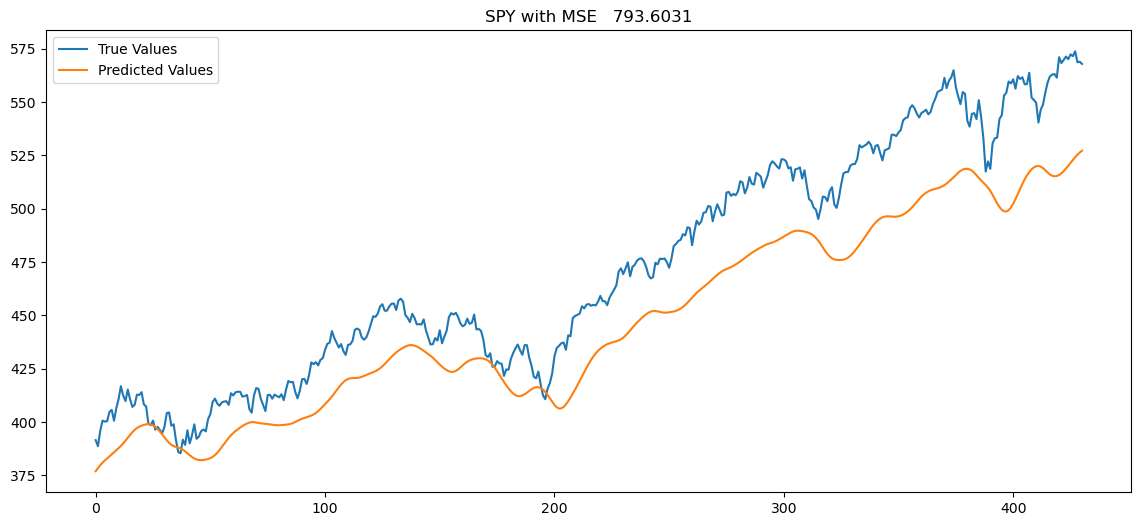

14/14 [==============================] - 0s 14ms/step


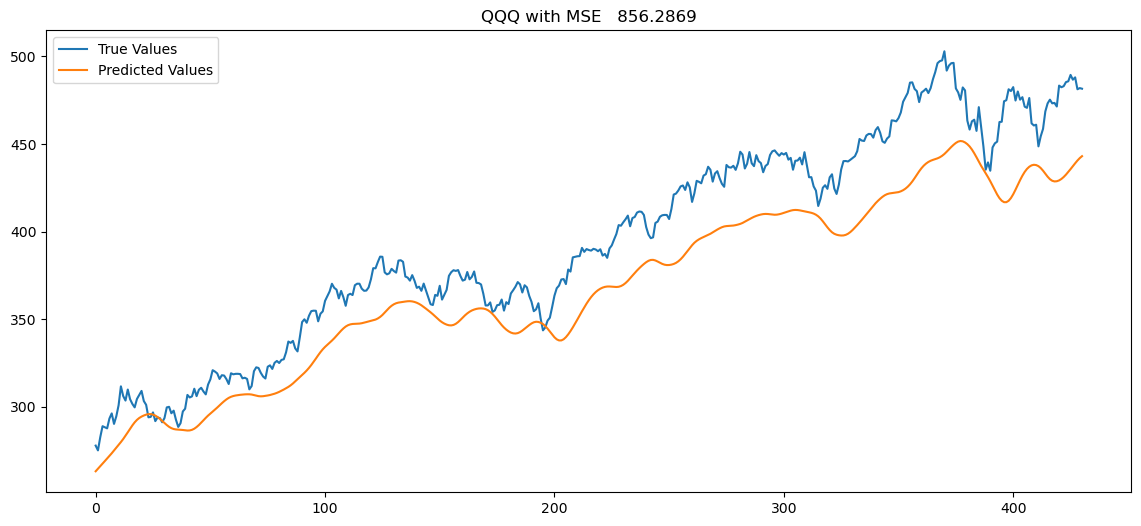

14/14 [==============================] - 0s 11ms/step


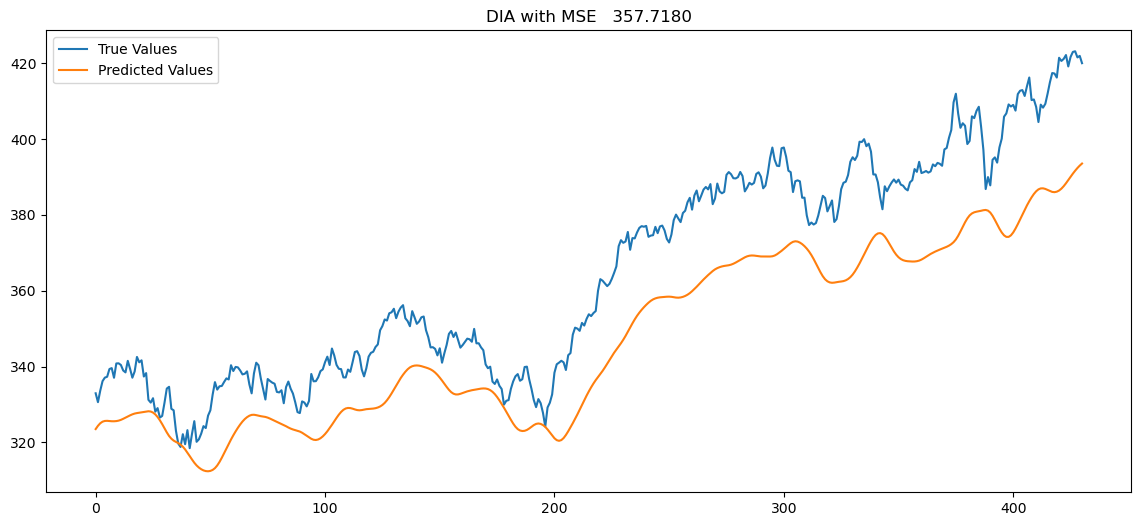

14/14 [==============================] - 0s 11ms/step


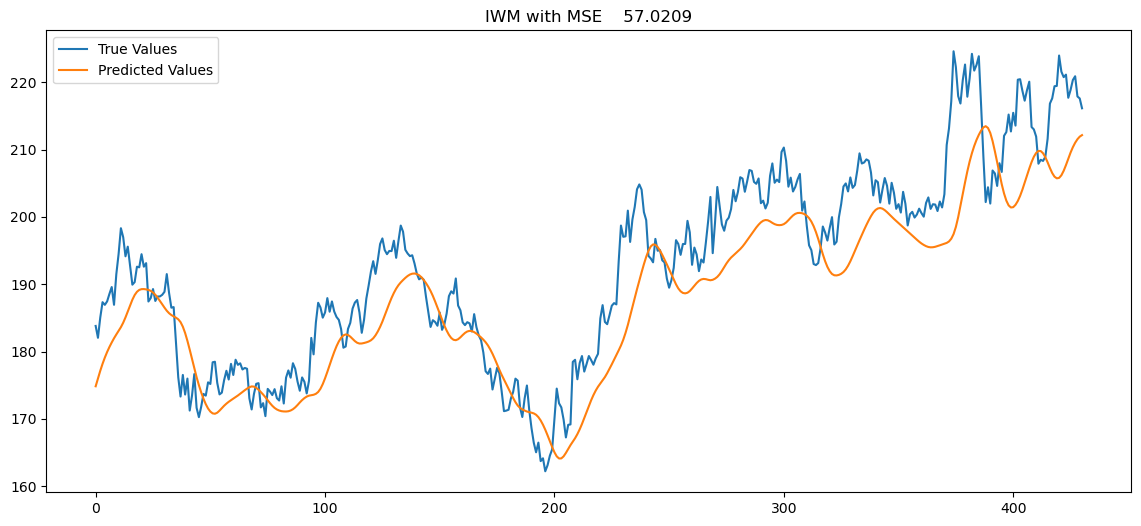

14/14 [==============================] - 0s 10ms/step


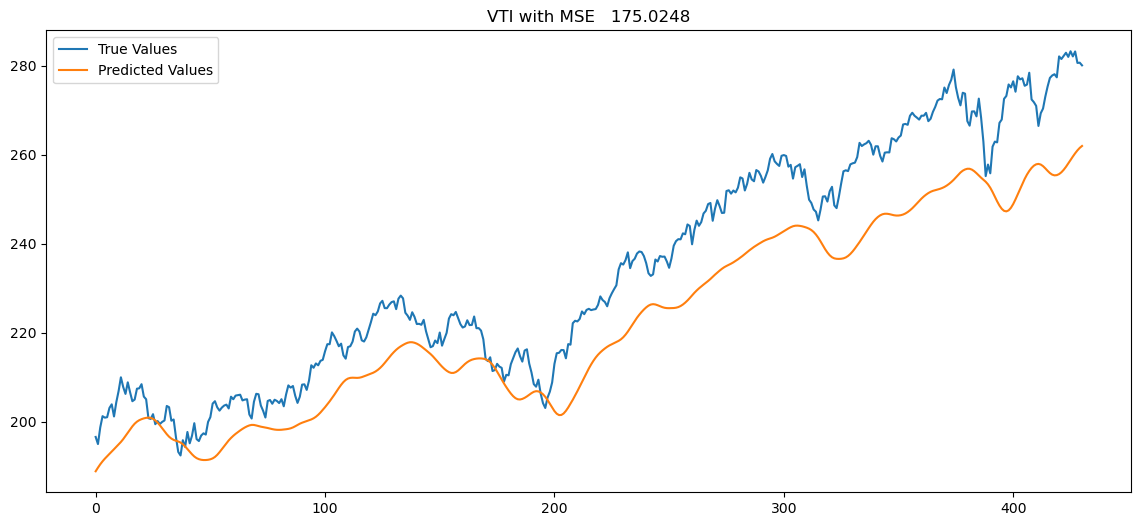

14/14 [==============================] - 0s 10ms/step


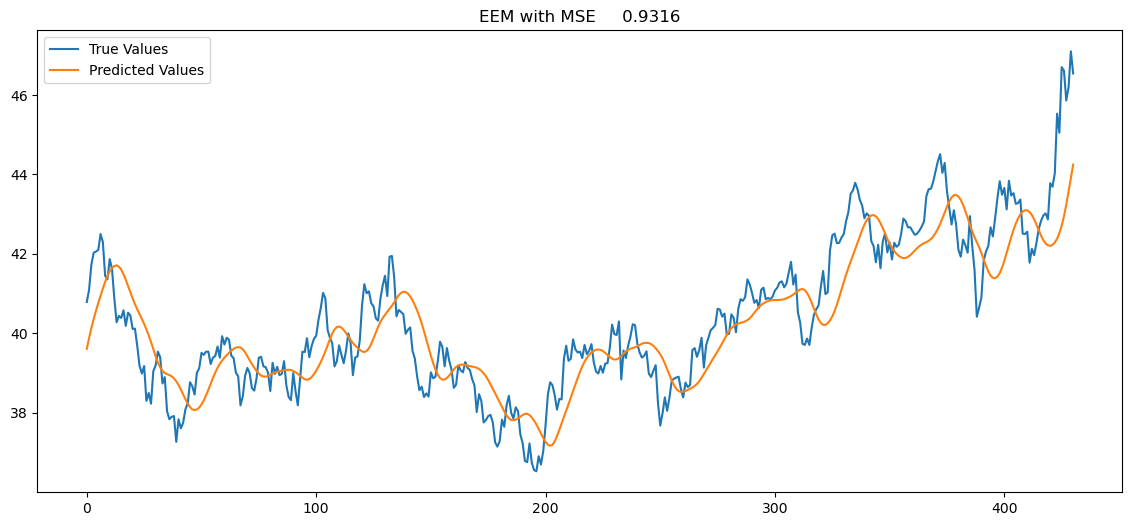

14/14 [==============================] - 0s 11ms/step


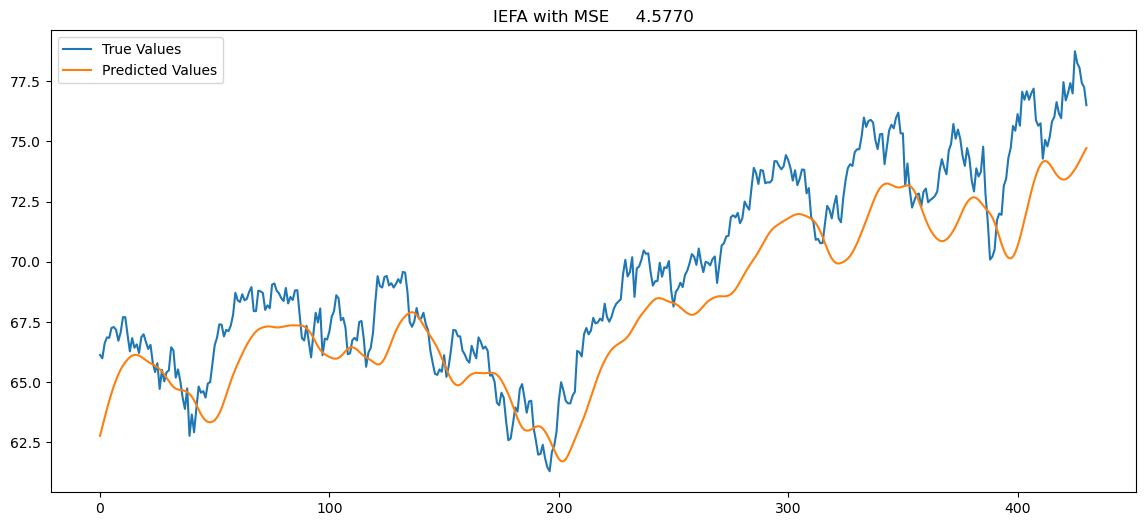

In [20]:

from sklearn.metrics import mean_squared_error 


# Dictionary to hold prediction results
pred_result = {}
for i in etfList:
    # Inverse transform the true and predicted values
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1, 1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    
    # Calculate Mean Squared Error
    MSE = mean_squared_error(y_true, y_pred)
    
    # Store results in the dictionary
    pred_result[i] = {
        "True": y_true,
        "Pred": y_pred
    }
    
    # Plotting the results
    plt.figure(figsize=(14, 6))
    plt.title("{} with MSE {:10.4f}".format(i, MSE))
    plt.plot(y_true, label='True Values')
    plt.plot(y_pred, label='Predicted Values')
    plt.legend()
    plt.show()


# Note
The initial model performance has not met expectations, prompting adjustments to improve its effectiveness. The following key changes have been made to the LSTM architecture:

- **Increased Units**: The number of LSTM units has been raised from 50 to 100. This change enables the model to capture more complex patterns in the data, enhancing its learning capacity.
- **Optimizer**: The optimizer has been switched to Adam, which features an adjustable learning rate. This optimizer is known for its efficiency and ability to converge faster in many cases.
- **Epochs and Batch Size**: The training duration has been extended to 50 epochs, and the batch size has been adjusted to 100. This allows for more comprehensive learning while potentially improving the model's ability to generalize.

These modifications aim to enhance the model's predictive performance and reduce the error in predictions.


In [21]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# Initialize the LSTM model architecture
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(trainset[etfList[0]]["X"].shape[1], 1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.5))

# Fourth LSTM layer
regressor.add(LSTM(units=100))
regressor.add(Dropout(0.5))

# The output layer
regressor.add(Dense(units=1))

# Compiling the LSTM model with an Adam optimizer and adjusted learning rate
optimizer = Adam(learning_rate=0.001)  # Adjust learning rate as needed
regressor.compile(optimizer=optimizer, loss='mean_squared_error')

# Fitting the model to the training set for each ETF
for etf in etfList:
    print(f"Fitting model for {etf}...")
    regressor.fit(trainset[etf]["X"], trainset[etf]["y"], epochs=50, batch_size=100)  # Increase epochs and adjust batch size


2024-10-04 18:38:18.802314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-04 18:38:18.802784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-04 18:38:18.803223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Fitting model for SPY...
Epoch 1/50


2024-10-04 18:38:19.056454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-04 18:38:19.057093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-04 18:38:19.057775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2024-10-04 18:38:20.469586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-04 18:38:20.470276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-04 18:38:20.470994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/20 [==============================] - 6s 155ms/step - loss: 0.0547
Epoch 2/50
20/20 [==============================] - 3s 152ms/step - loss: 0.0107
Epoch 3/50
20/20 [==============================] - 3s 152ms/step - loss: 0.0061
Epoch 4/50
20/20 [==============================] - 3s 153ms/step - loss: 0.0053
Epoch 5/50
20/20 [==============================] - 3s 154ms/step - loss: 0.0057
Epoch 6/50
20/20 [==============================] - 3s 158ms/step - loss: 0.0062
Epoch 7/50
20/20 [==============================] - 3s 158ms/step - loss: 0.0097
Epoch 8/50
20/20 [==============================] - 3s 158ms/step - loss: 0.0050
Epoch 9/50
20/20 [==============================] - 3s 158ms/step - loss: 0.0046
Epoch 10/50
20/20 [==============================] - 3s 158ms/step - loss: 0.0045
Epoch 11/50
20/20 [==============================] - 3s 158ms/step - loss: 0.0058
Epoch 12/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0052
Epoch 13/50
20/20 [=================

Fitting model for DIA...
Epoch 1/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0024
Epoch 2/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0027
Epoch 3/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0027
Epoch 4/50
20/20 [==============================] - 3s 160ms/step - loss: 0.0024
Epoch 5/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0023
Epoch 6/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0027
Epoch 7/50
20/20 [==============================] - 3s 160ms/step - loss: 0.0026
Epoch 8/50
20/20 [==============================] - 3s 160ms/step - loss: 0.0024
Epoch 9/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0024
Epoch 10/50
20/20 [==============================] - 3s 161ms/step - loss: 0.0024
Epoch 11/50
20/20 [==============================] - 3s 162ms/step - loss: 0.0022
Epoch 12/50
20/20 [==============================] - 3s 162ms/step - loss: 0.0023


20/20 [==============================] - 3s 162ms/step - loss: 0.0013
Fitting model for VTI...
Epoch 1/50
20/20 [==============================] - 3s 160ms/step - loss: 0.0016
Epoch 2/50
20/20 [==============================] - 3s 174ms/step - loss: 0.0013
Epoch 3/50
20/20 [==============================] - 3s 161ms/step - loss: 0.0014
Epoch 4/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0014
Epoch 5/50
20/20 [==============================] - 3s 162ms/step - loss: 0.0013
Epoch 6/50
20/20 [==============================] - 3s 163ms/step - loss: 0.0015
Epoch 7/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0013
Epoch 8/50
20/20 [==============================] - 3s 161ms/step - loss: 0.0012
Epoch 9/50
20/20 [==============================] - 3s 160ms/step - loss: 0.0014
Epoch 10/50
20/20 [==============================] - 3s 161ms/step - loss: 0.0013
Epoch 11/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0017
Epoch 12/50


20/20 [==============================] - 3s 158ms/step - loss: 0.0010
Epoch 50/50
20/20 [==============================] - 3s 164ms/step - loss: 0.0014
Fitting model for IEFA...
Epoch 1/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0012
Epoch 2/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0014
Epoch 3/50
20/20 [==============================] - 3s 160ms/step - loss: 0.0014
Epoch 4/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0012
Epoch 5/50
20/20 [==============================] - 3s 161ms/step - loss: 0.0012
Epoch 6/50
20/20 [==============================] - 3s 160ms/step - loss: 0.0011
Epoch 7/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0012
Epoch 8/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0011
Epoch 9/50
20/20 [==============================] - 3s 159ms/step - loss: 0.0012
Epoch 10/50
20/20 [==============================] - 3s 160ms/step - loss: 0.0012
Epoch 11/50

2024-10-04 18:57:22.063056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-04 18:57:22.064296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-04 18:57:22.064838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/14 [==============================] - 1s 27ms/step


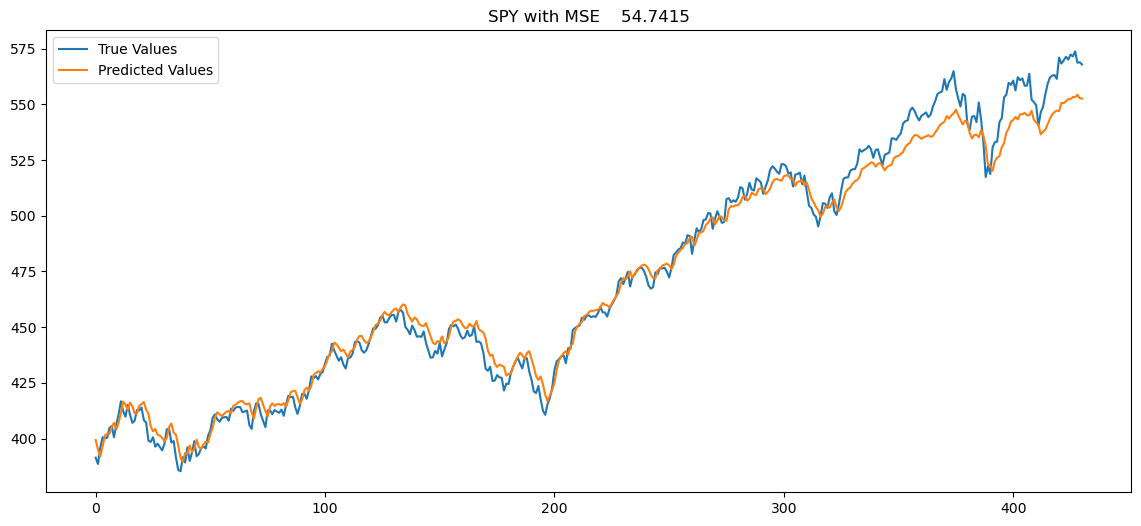

14/14 [==============================] - 0s 26ms/step


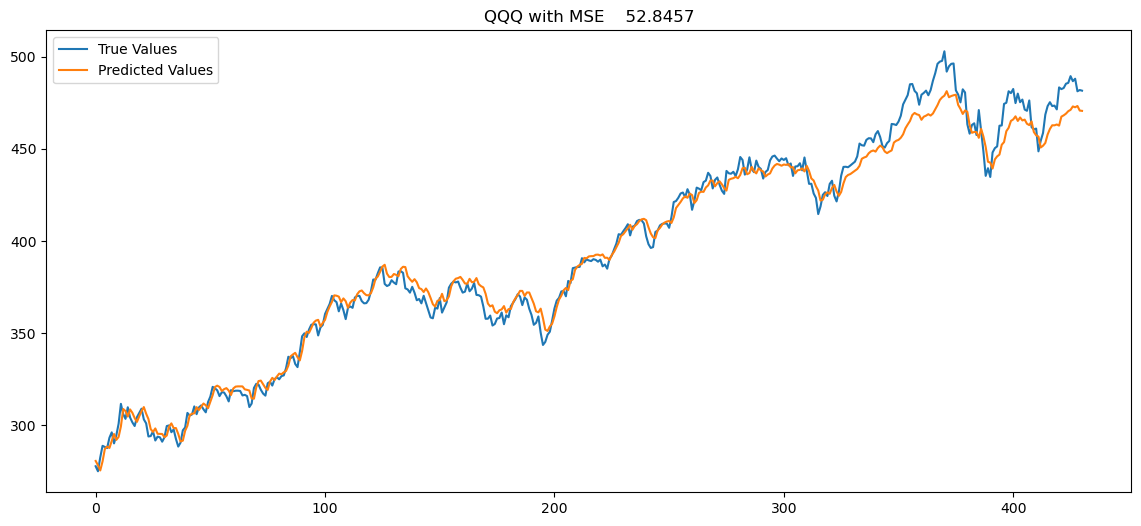

14/14 [==============================] - 0s 25ms/step


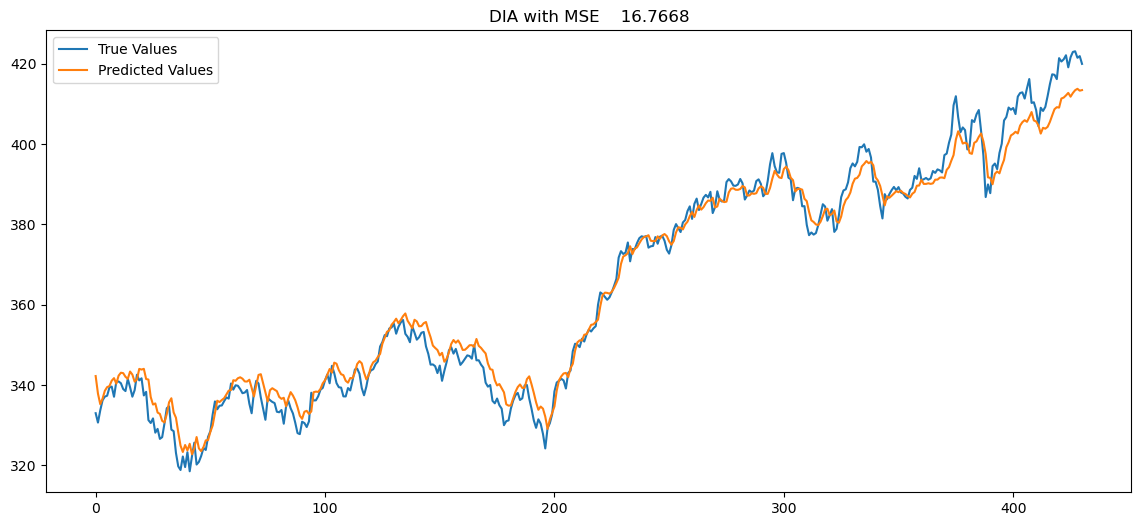

14/14 [==============================] - 0s 25ms/step


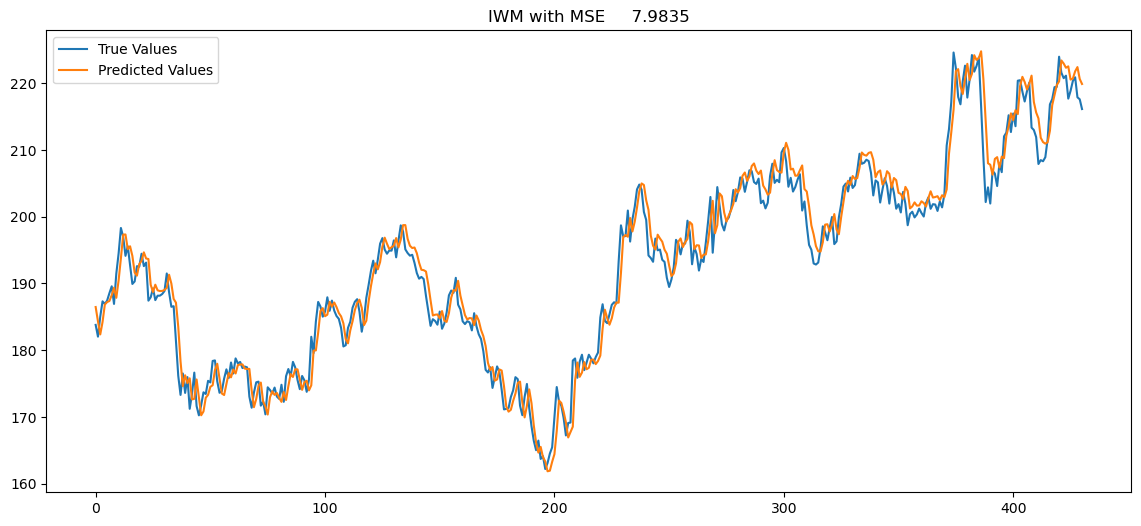

14/14 [==============================] - 0s 26ms/step


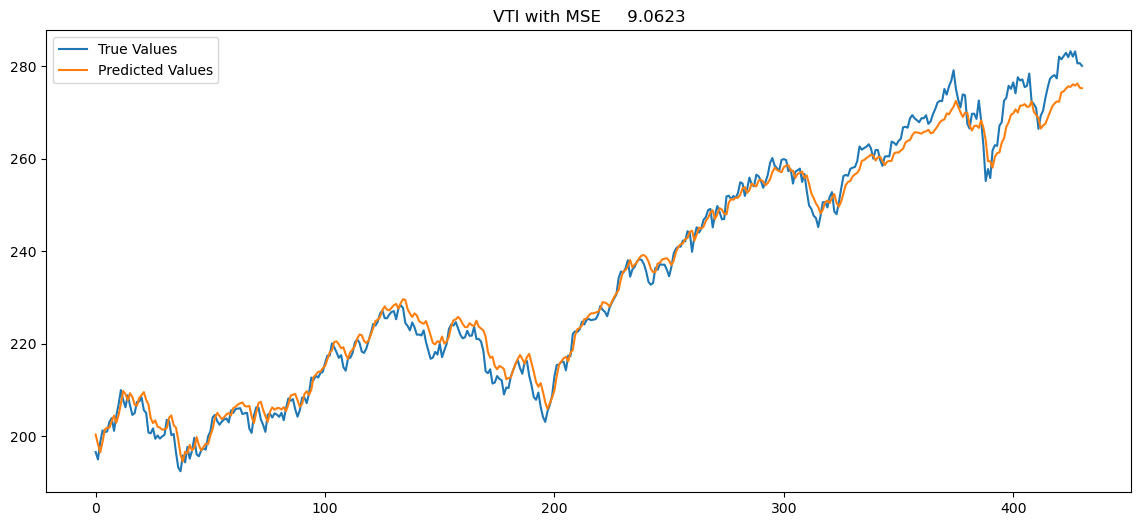

14/14 [==============================] - 0s 26ms/step


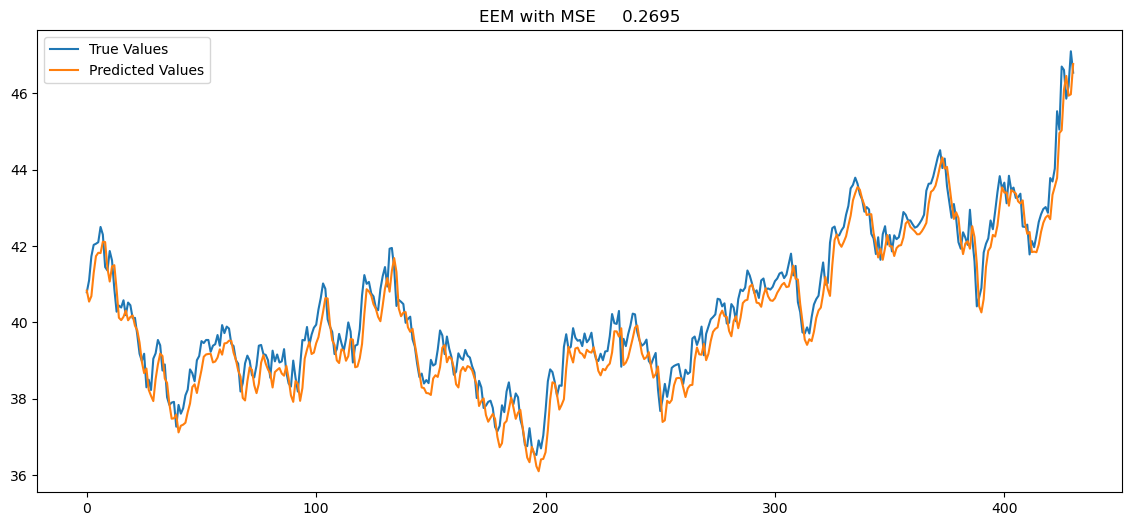

14/14 [==============================] - 0s 27ms/step


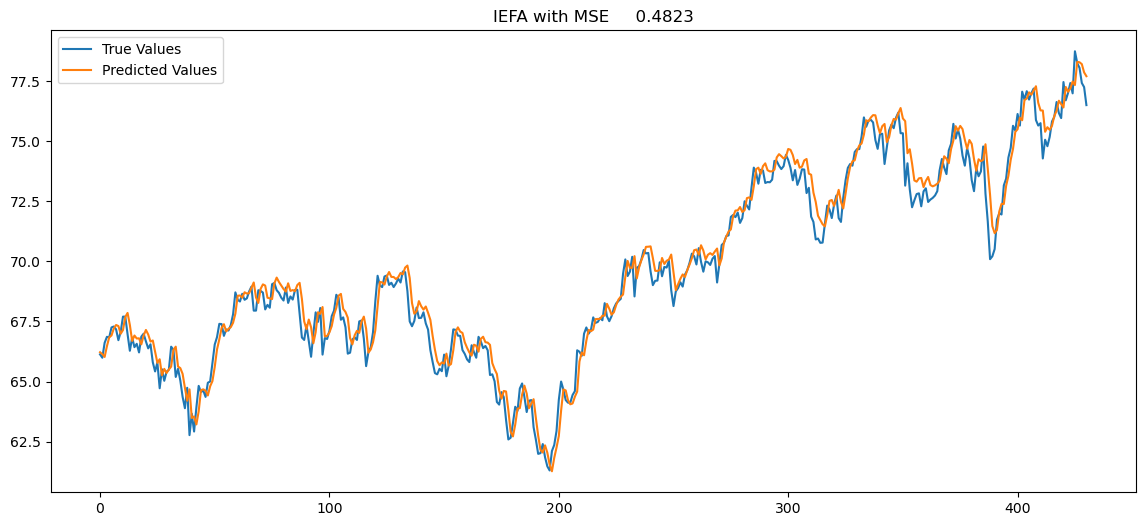

In [22]:

from sklearn.metrics import mean_squared_error 


# Dictionary to hold prediction results
pred_result = {}
for i in etfList:
    # Inverse transform the true and predicted values
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1, 1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    
    # Calculate Mean Squared Error
    MSE = mean_squared_error(y_true, y_pred)
    
    # Store results in the dictionary
    pred_result[i] = {
        "True": y_true,
        "Pred": y_pred
    }
    
    # Plotting the results
    plt.figure(figsize=(14, 6))
    plt.title("{} with MSE {:10.4f}".format(i, MSE))
    plt.plot(y_true, label='True Values')
    plt.plot(y_pred, label='Predicted Values')
    plt.legend()
    plt.show()


In [23]:
time_index = df_new["SPY"]["Test"][60:].index
def lagging(df, lag, time_index):
    df_pred = pd.Series(df["Pred"].reshape(-1), index=test_index)
    df_true = pd.Series(df["True"].reshape(-1), index=test_index)
    
    df_pred_lag = df_pred.shift(lag)
    
    print("MSE without Lag", mean_squared_error(np.array(df_true), np.array(df_pred)))
    print("MSE with Lag 5", mean_squared_error(np.array(df_true[:-5]), np.array(df_pred_lag[:-5])))

    plt.figure(figsize=(14,4))
    plt.title("Prediction without Lag")
    plt.plot(df_true)
    plt.plot(df_pred)

    MSE_lag = mean_squared_error(np.array(df_true[:-5]), np.array(df_pred_lag[:-5]))
    plt.figure(figsize=(14,4))
    plt.title("Prediction with Lag")
    plt.plot(df_true)
    plt.plot(df_pred_lag)

/var/folders/df/3l1d54kj4v1bv3cvv3xvvm200000gn/T/ipykernel_23563/375514040.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  time_index = df_new["SPY"]["Test"][60:].index


We can enhance our predictions by implementing lagging or shifting techniques. In this context, lagging refers to the practice of sliding our predictions back in time. This method is commonly utilized in signal processing. When we lag our predictions to begin earlier, the last values will be NaN (Not a Number) for the duration of the lag. For instance, if we lag our predictions by 2 days, the last 2 days of predictions will become NaN.

Conversely, shifting involves moving our predictions forward in time. Similar to lagging, shifted predictions will also have initial values equal to NaN, corresponding to the amount of displacement. Thus, if we shift our predictions by 2 days, the first 2 predictions will be NaN.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming df_new is already defined and contains the required structure

time_index = df_new["SPY"]["Test"][60:].index

def lagging(df, lag, time_index):
    # Create Series for predicted and true values using time_index
    df_pred = pd.Series(df["Pred"].reshape(-1), index=time_index)
    df_true = pd.Series(df["True"].reshape(-1), index=time_index)
    
    # Shift predictions by lag
    df_pred_lag = df_pred.shift(lag)

    # Calculate MSE without lag
    mse_without_lag = mean_squared_error(df_true, df_pred)
    print("MSE without Lag:", mse_without_lag)

    # Calculate MSE with lag, ensuring to align the indices correctly
    mse_with_lag = mean_squared_error(df_true[:-lag], df_pred_lag[:-lag])  # Adjust for lag
    print("MSE with Lag {}: {}".format(lag, mse_with_lag))

    # Plotting predictions without lag
    plt.figure(figsize=(14, 4))
    plt.title("Prediction without Lag")
    plt.plot(df_true, label='True Values', color='blue')
    plt.plot(df_pred, label='Predicted Values', color='orange', alpha=0.7)
    plt.legend()
    plt.show()

    # Plotting predictions with lag
    plt.figure(figsize=(14, 4))
    plt.title("Prediction with Lag of {}".format(lag))
    plt.plot(df_true, label='True Values', color='blue')
    plt.plot(df_pred_lag, label='Lagged Predicted Values', color='orange', alpha=0.7)
    plt.legend()
    plt.show()


/var/folders/df/3l1d54kj4v1bv3cvv3xvvm200000gn/T/ipykernel_23563/877703047.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  time_index = df_new["SPY"]["Test"][60:].index


Calculating lagging for SPY...
MSE without Lag: 54.74151230951136
MSE with Lag -2: 30.091552772559666


/var/folders/df/3l1d54kj4v1bv3cvv3xvvm200000gn/T/ipykernel_23563/3847670495.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lagging(pred_result[etf], lag=-2, time_index=df_new[etf]["Test"][60:].index)
/var/folders/df/3l1d54kj4v1bv3cvv3xvvm200000gn/T/ipykernel_23563/1707423194.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  mse_with_lag = mean_squared_error(df_true[:-lag], df_pred_lag[:-lag])  # Adjust for lag


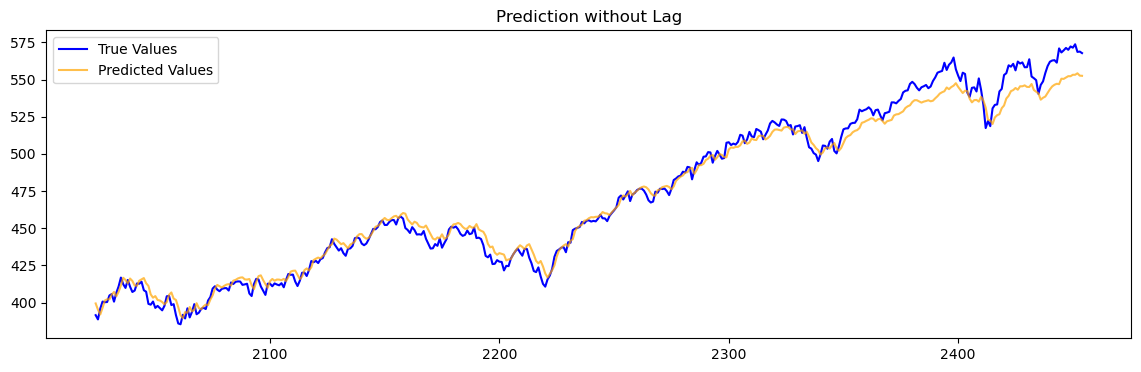

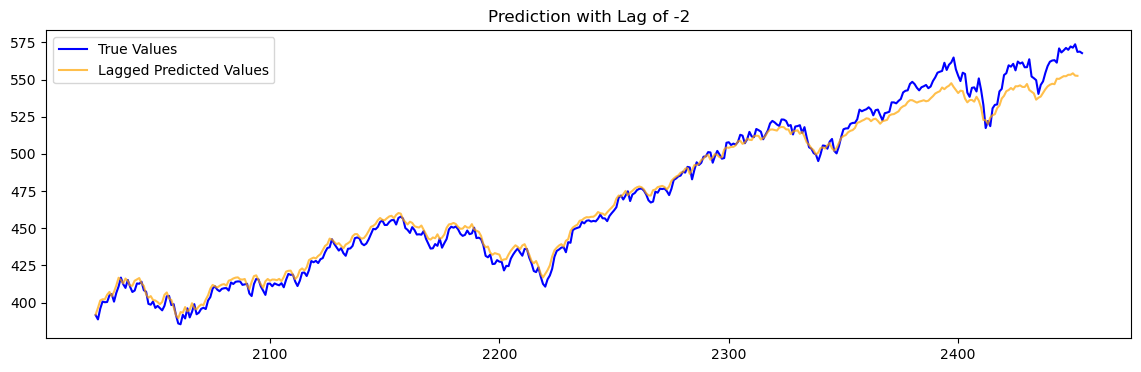

Calculating lagging for QQQ...
MSE without Lag: 52.84567693179677
MSE with Lag -2: 16.84355143085122


/var/folders/df/3l1d54kj4v1bv3cvv3xvvm200000gn/T/ipykernel_23563/3847670495.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lagging(pred_result[etf], lag=-2, time_index=df_new[etf]["Test"][60:].index)
/var/folders/df/3l1d54kj4v1bv3cvv3xvvm200000gn/T/ipykernel_23563/1707423194.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  mse_with_lag = mean_squared_error(df_true[:-lag], df_pred_lag[:-lag])  # Adjust for lag


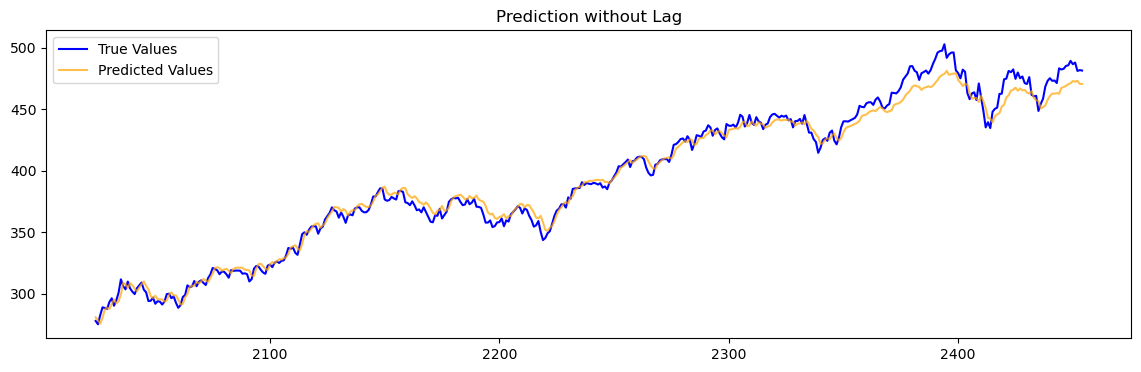

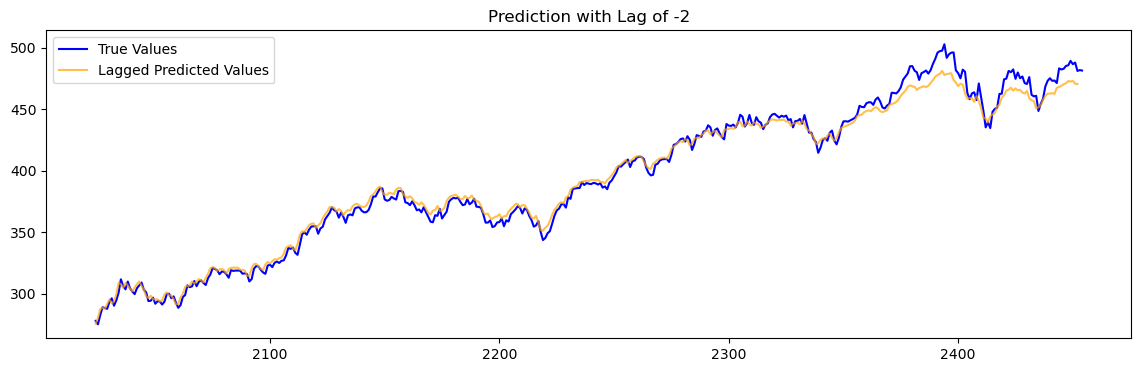

Calculating lagging for DIA...
MSE without Lag: 16.76680189879983
MSE with Lag -2: 20.249761498067528


/var/folders/df/3l1d54kj4v1bv3cvv3xvvm200000gn/T/ipykernel_23563/3847670495.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lagging(pred_result[etf], lag=-2, time_index=df_new[etf]["Test"][60:].index)
/var/folders/df/3l1d54kj4v1bv3cvv3xvvm200000gn/T/ipykernel_23563/1707423194.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  mse_with_lag = mean_squared_error(df_true[:-lag], df_pred_lag[:-lag])  # Adjust for lag


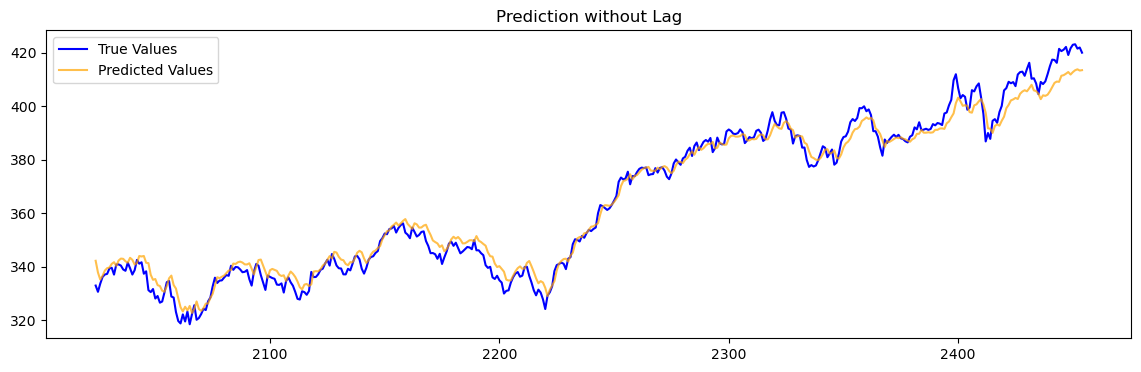

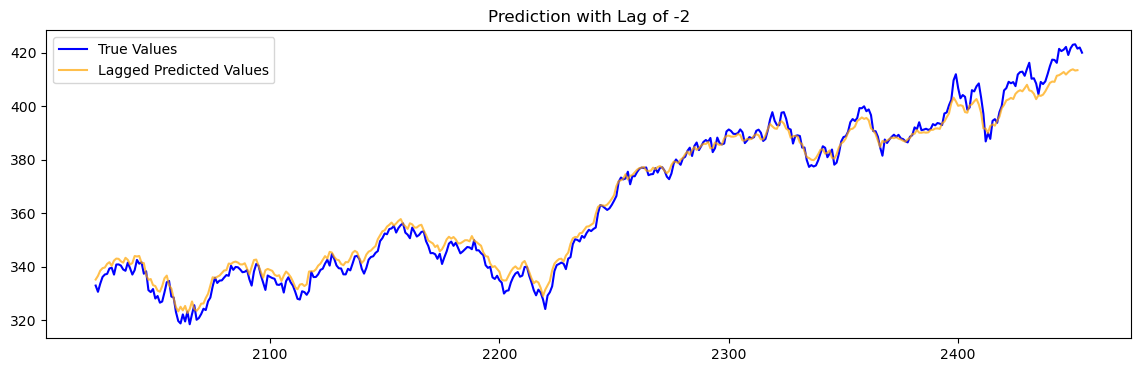

Calculating lagging for IWM...
MSE without Lag: 7.9834515150256085
MSE with Lag -2: 3.43578417156823


/var/folders/df/3l1d54kj4v1bv3cvv3xvvm200000gn/T/ipykernel_23563/3847670495.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lagging(pred_result[etf], lag=-2, time_index=df_new[etf]["Test"][60:].index)
/var/folders/df/3l1d54kj4v1bv3cvv3xvvm200000gn/T/ipykernel_23563/1707423194.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  mse_with_lag = mean_squared_error(df_true[:-lag], df_pred_lag[:-lag])  # Adjust for lag


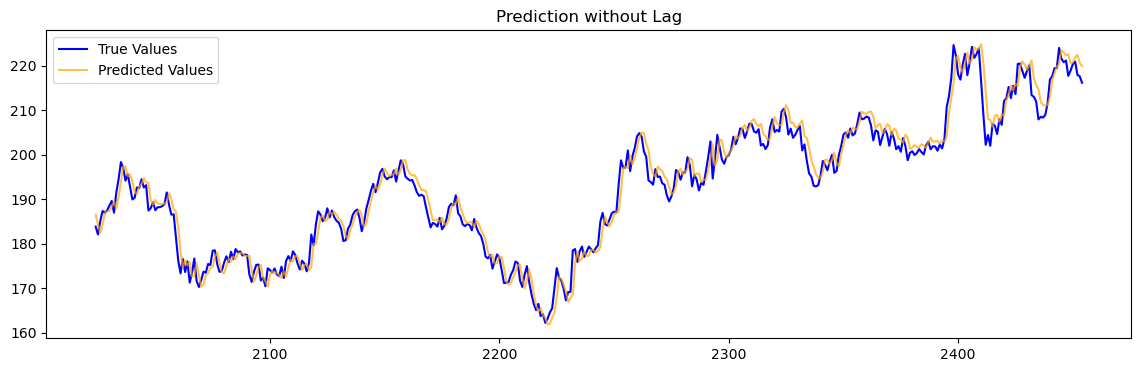

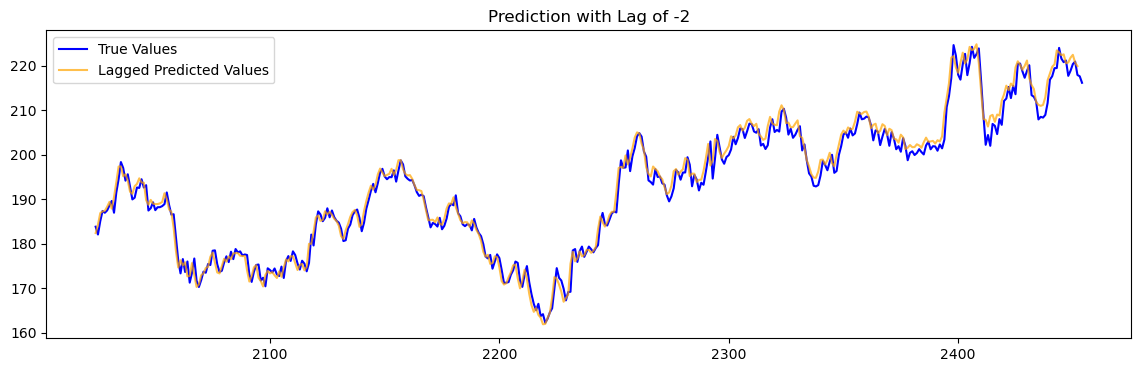

Calculating lagging for VTI...
MSE without Lag: 9.062348309183673
MSE with Lag -2: 7.249011608888395


/var/folders/df/3l1d54kj4v1bv3cvv3xvvm200000gn/T/ipykernel_23563/3847670495.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lagging(pred_result[etf], lag=-2, time_index=df_new[etf]["Test"][60:].index)
/var/folders/df/3l1d54kj4v1bv3cvv3xvvm200000gn/T/ipykernel_23563/1707423194.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  mse_with_lag = mean_squared_error(df_true[:-lag], df_pred_lag[:-lag])  # Adjust for lag


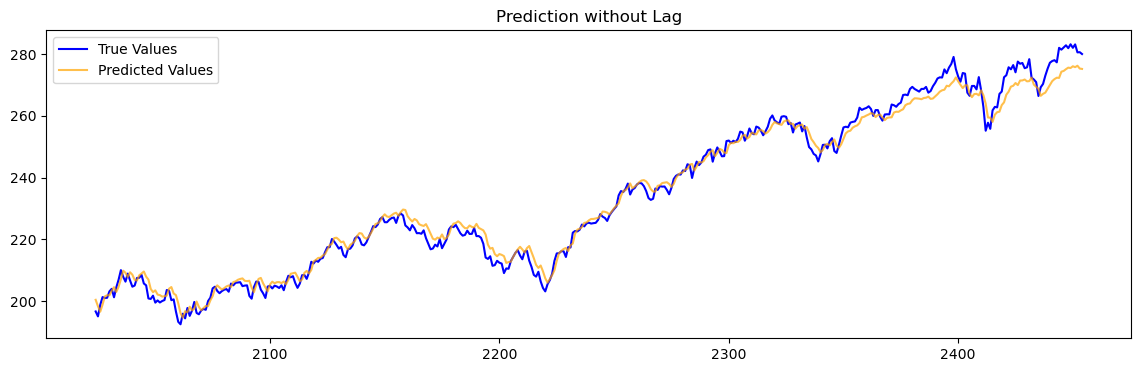

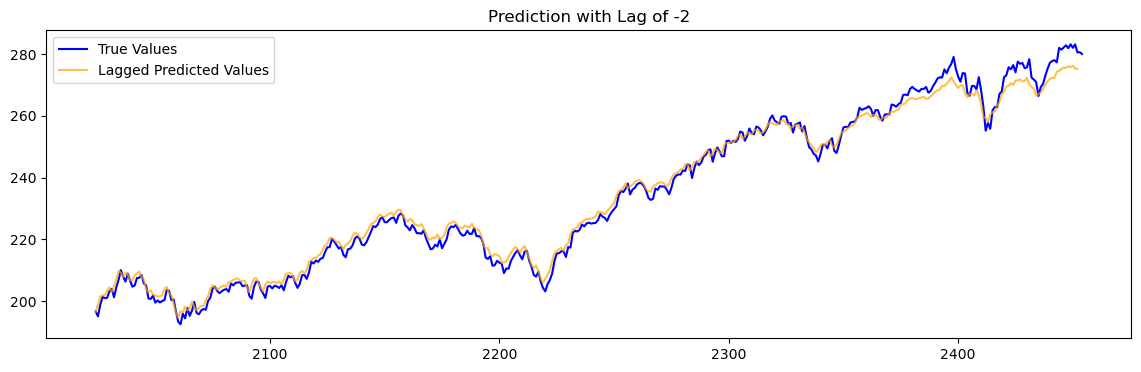

Calculating lagging for EEM...
MSE without Lag: 0.26949581014738055
MSE with Lag -2: 0.02360431815031916


/var/folders/df/3l1d54kj4v1bv3cvv3xvvm200000gn/T/ipykernel_23563/3847670495.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lagging(pred_result[etf], lag=-2, time_index=df_new[etf]["Test"][60:].index)
/var/folders/df/3l1d54kj4v1bv3cvv3xvvm200000gn/T/ipykernel_23563/1707423194.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  mse_with_lag = mean_squared_error(df_true[:-lag], df_pred_lag[:-lag])  # Adjust for lag


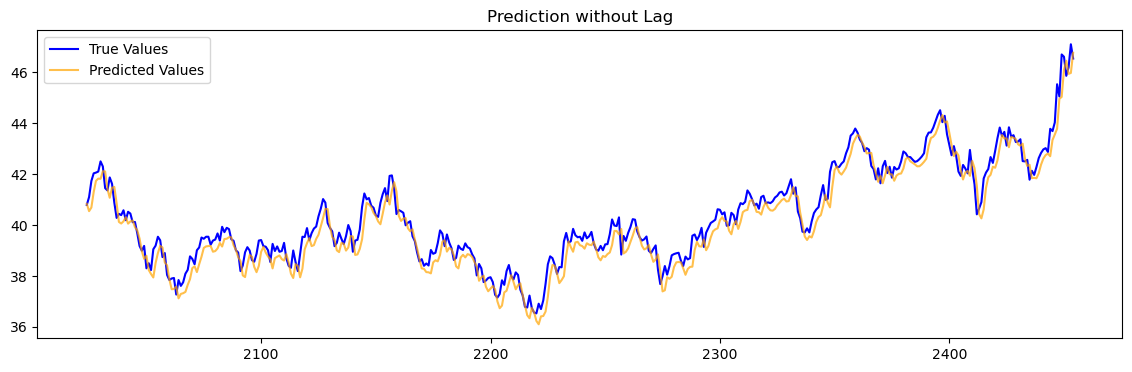

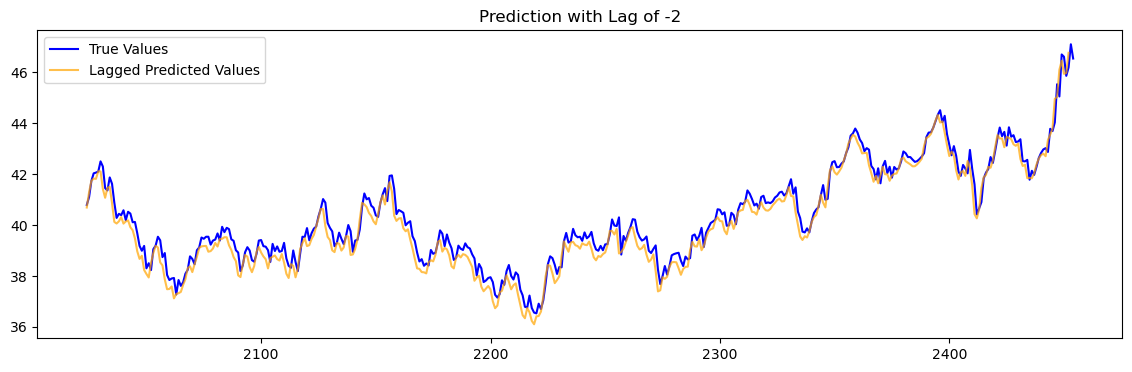

Calculating lagging for IEFA...
MSE without Lag: 0.4823291752698573
MSE with Lag -2: 0.12050792947411537


/var/folders/df/3l1d54kj4v1bv3cvv3xvvm200000gn/T/ipykernel_23563/3847670495.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lagging(pred_result[etf], lag=-2, time_index=df_new[etf]["Test"][60:].index)
/var/folders/df/3l1d54kj4v1bv3cvv3xvvm200000gn/T/ipykernel_23563/1707423194.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  mse_with_lag = mean_squared_error(df_true[:-lag], df_pred_lag[:-lag])  # Adjust for lag


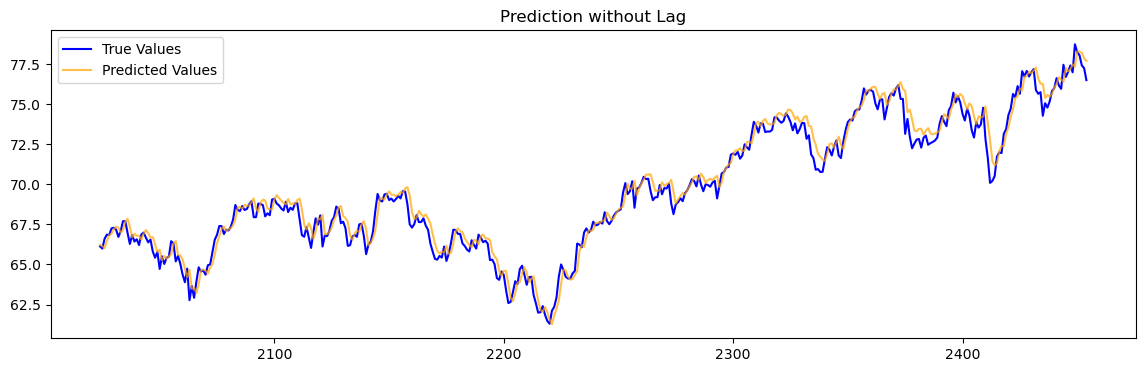

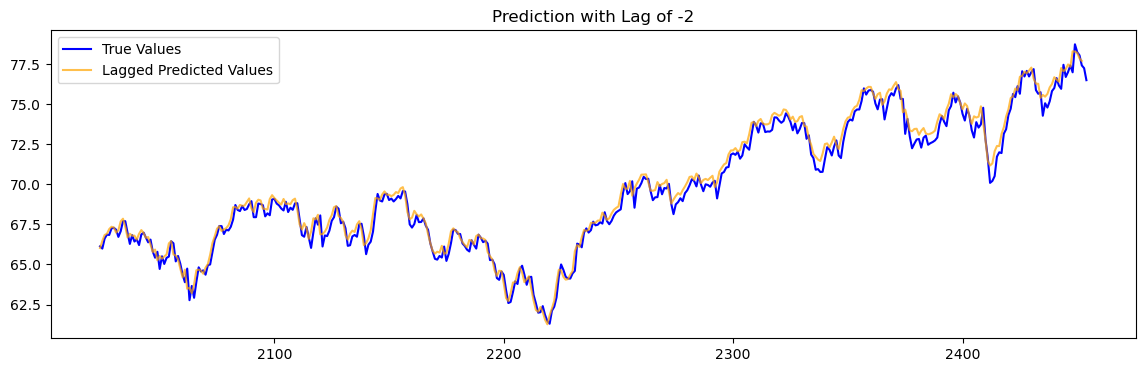

In [29]:
for etf in etfList:
    print(f"Calculating lagging for {etf}...")
    lagging(pred_result[etf], lag=-2, time_index=df_new[etf]["Test"][60:].index)
